In [24]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("./data.csv", low_memory=False)

In [237]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,NaN,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,NaN,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [238]:
df1 = df.dropna(axis=1, thresh=int(0.80*len(df)))

In [239]:
df1.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,debt_settlement_flag
0,1077501,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,...,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N
1,1077430,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,...,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N
2,1077175,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,...,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N
3,1076863,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,...,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N
4,1075358,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,...,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,N


### Total columns in Loan dataset

In [240]:
len(df.columns)

150

### Columns after removing missing data cols

In [241]:
len(df1.columns)

58

### Select necessary columns for analysis

In [242]:
df_LC = df1.filter(['loan_amnt','term','int_rate','installment','grade','sub_grade','emp_length','home_ownership',
                    'annual_inc','verification_status','purpose','dti','delinq_2yrs','loan_status'])

### Lets look at the types of target class

In [243]:
df_LC['loan_status'].value_counts()

Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

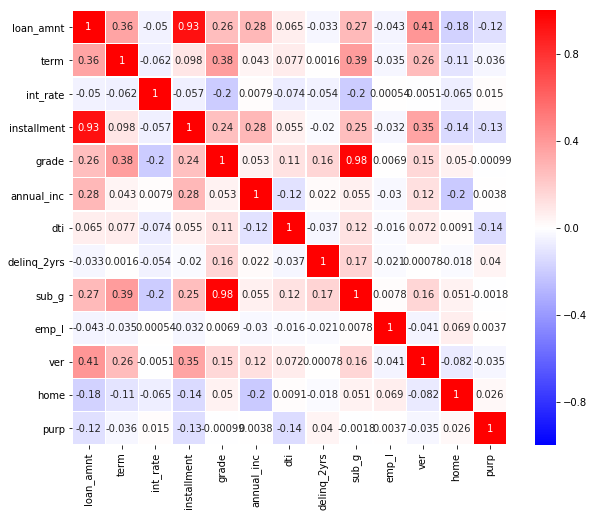

In [244]:
##finding the correlation matrix and changing the categorical data to category for the plot.
plt.subplots(figsize=(10,8))
sns.heatmap(df_LC.assign(grade=df_LC.grade.astype('category').cat.codes,
                         sub_g=df_LC.sub_grade.astype('category').cat.codes,
                         term=df_LC.term.astype('category').cat.codes,
                         emp_l=df_LC.emp_length.astype('category').cat.codes,
                         ver=df_LC.verification_status.astype('category').cat.codes,
                         home=df_LC.home_ownership.astype('category').cat.codes,
                         int_rate=df_LC.int_rate.astype('category').cat.codes,
                         purp=df_LC.purpose.astype('category').cat.codes).corr(), 
                         annot=True, cmap='bwr',vmin=-1, vmax=1, square=True, linewidths=0.5)

It can be seen from the plot above that loan amount and installment have a very high correlation amongst each other (0.94). This is intuitive since a person who takes a large sum of loan would require extra time to repay it back. Also, interest rate, sub grade and grade have a very high correlation between them. This is obvious since interest rate is decided by grades once the grades are decided, a subgrade is assigned to that loan (leading to high correlation).

Let's drop the three categories alongwith term and verification status(since it doesn't provide any valuable info) for further analysis.

In [245]:
df_LC.drop(['installment','grade','sub_grade','verification_status','term'],
           axis=1, inplace = True)

In [246]:
#printing the count and null values in the dataframe
dflc_null = pd.DataFrame({'Count': df_LC.isnull().sum(), 'Percent': 100*df_LC.isnull().sum()/len(df_LC)})
dflc_null[dflc_null['Count'] > 0]

,Count,Percent
loan_amnt,7,0.016454
int_rate,7,0.016454
emp_length,1119,2.630342
home_ownership,7,0.016454
annual_inc,11,0.025857
purpose,7,0.016454
dti,7,0.016454
delinq_2yrs,36,0.084622
loan_status,7,0.016454


In [247]:
## dropping the null rows since we have sufficient amount of data and there is no need to fill the null values.
df_LC.dropna(axis=0)

,loan_amnt,int_rate,emp_length,home_ownership,annual_inc,purpose,dti,delinq_2yrs,loan_status
0,5000.0,10.65%,10+ years,RENT,24000.00,credit_card,27.65,0.0,Fully Paid
1,2500.0,15.27%,< 1 year,RENT,30000.00,car,1.00,0.0,Charged Off
2,2400.0,15.96%,10+ years,RENT,12252.00,small_business,8.72,0.0,Fully Paid
3,10000.0,13.49%,10+ years,RENT,49200.00,other,20.00,0.0,Fully Paid
4,3000.0,12.69%,1 year,RENT,80000.00,other,17.94,0.0,Fully Paid
5,5000.0,7.90%,3 years,RENT,36000.00,wedding,11.20,0.0,Fully Paid
6,7000.0,15.96%,8 years,RENT,47004.00,debt_consolidation,23.51,0.0,Fully Paid
7,3000.0,18.64%,9 years,RENT,48000.00,car,5.35,0.0,Fully Paid
8,5600.0,21.28%,4 years,OWN,40000.00,small_business,5.55,0.0,Charged Off
9,5375.0,12.69%,< 1 year,RENT,15000.00,other,18.08,0.0,Charged Off


In [248]:
df_LC['loan_status'].unique()

array(['Fully Paid', 'Charged Off', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

### Distribution of the loan status values
Let us now see how the values in the status column are distributed. We will plot an histogram of values against count of times the status appears on the dataframe

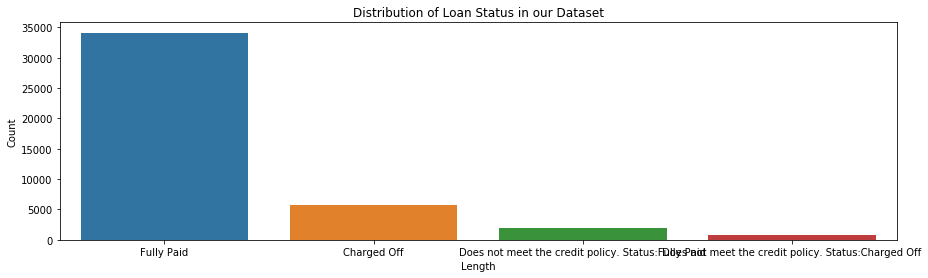

In [249]:
m =df_LC['loan_status'].value_counts()
m = m.to_frame()
m.reset_index(inplace=True)
m.columns = ['Loan Status','Count']
plt.subplots(figsize=(15,4))
sns.barplot(y='Count', x='Loan Status', data=m)
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Loan Status in our Dataset")
plt.show()

As you can see, we have a lot of loans which are current with fair amount of fully paid loans. other categories (including) default have a really low number. This means the data is imbalanced and we might need to do something about this later in the analysis. For now we will drop all the columns except 'Fully Paid', 'Default' and 'Charged off'. We will also merge 'Charged off' and 'Default' together meaning that anyone who fell into this category defaulted their loan. The following two parts tries to implement this.

In [250]:
df_LC = df_LC[df_LC.loan_status != 'Does not meet the credit policy. Status:Fully Paid']
df_LC = df_LC[df_LC.loan_status != 'Does not meet the credit policy. Status:Charged Off']
df_LC = df_LC[pd.notnull(df_LC.loan_status)]

In [251]:
df_LC['loan_status'] = df_LC['loan_status'].replace({'Charged Off':'Default'})
df_LC['loan_status'].value_counts()

Fully Paid    34116
Default        5670
Name: loan_status, dtype: int64

We will now encode the two categories listed above as 0 or 1 for our analysis. This will help us in predicting whether a person defaulted their loan or not. 0 means he deaulted and 1 means he paid off his loan.

In [252]:
df_LC.loan_status=df_LC.loan_status.astype('category').cat.codes
df_LC.delinq_2yrs=df_LC.delinq_2yrs.astype('category').cat.codes
df_LC.head()
df_LC['loan_status'].value_counts()

1    34116
0     5670
Name: loan_status, dtype: int64

In [253]:
df_LC['emp_length'] = df_LC['emp_length'].replace({'< 1 year': '0 years', '10+ years': '11 years'})

In [254]:
df_LC['emp_length'] = df_LC['emp_length'].str.extract('(\d+)').astype('float')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


In [255]:
df_LC['emp_length'] = df_LC['emp_length'].fillna(round(df_LC['emp_length'].mean(), 1))

In [256]:
df_LC['int_rate'] = df_LC['int_rate'].str.extract('(\d+)').astype('float')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


In [257]:
df_LC.columns.tolist()

['loan_amnt',
 'int_rate',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'purpose',
 'dti',
 'delinq_2yrs',
 'loan_status']

In [258]:
df_LC_dummies = [pd.get_dummies(df_LC['home_ownership'], prefix = 'home_ownership', prefix_sep = '_'),
#                      pd.get_dummies(df_LC['loan_status'], prefix = 'loan_status', prefix_sep = '_'),
                     pd.get_dummies(df_LC['purpose'], prefix = 'purpose', prefix_sep = '_')]
# We create dummy variables from all 8 original independent variables, and save them into a list.
# Note that we are using a particular naming convention for all variables: original variable name, colon, category name.

In [259]:
df_LC_dummies = pd.concat(df_LC_dummies, axis = 1)
# We concatenate the dummy variables and this turns them into a dataframe.

In [260]:
df_LC = pd.concat([df_LC, df_LC_dummies], axis = 1)
# Concatenates two dataframes.

In [261]:
df_LC = df_LC.drop(['home_ownership', 'purpose'], axis=1)

In [262]:
traindata, testdata = train_test_split(df_LC, stratify=df_LC['loan_status'],test_size=.4, random_state=17)
testdata.reset_index(drop=True, inplace=True)
traindata.reset_index(drop=True, inplace=True)

Now Scale the data so that each column has a mean of zero and unit standard deviation. Xunb (unbalanced set) and yunb are the independent and target variable.

In [263]:
sc = StandardScaler()
Xunb = traindata.drop('loan_status', axis=1)
yunb = traindata['loan_status']
numerical = Xunb.columns[(Xunb.dtypes == 'float64') | (Xunb.dtypes == 'int64')].tolist()
Xunb[numerical] = sc.fit_transform(Xunb[numerical])

### Model Selection
Now ready to build some models.The following would be approach for building and selecting the best model:

Build a model on the imbalance dataset we got from data cleaning.
Balance the dataset by using equal amount of default and 'fully paid' loans.

### Trying the Unbalanced Dataset
Let's first try the unbalanced dataset.The function below computes the receiver operating characteristic (ROC) curves for each of the models. This function will be called later in the analysis.

In [264]:
def createROC(models, X, y, Xte, yte):
    false_p, true_p = [], [] ##false postives and true positives

    for i in models.keys():  ##dict of models
        models[i].fit(X, y)

        fp, tp, threshold = roc_curve(yte, models[i].predict_proba(Xte)[:,1]) ##roc_curve function

        true_p.append(tp)
        false_p.append(fp)
    return true_p, false_p ##returning the true postive and false positive

I will try few models on the train dataset With 3 fold cross validation:

1. Linear Discriminant Analysis
2. Multinomial Naive Bayes
3. Random Forest (tree based model)
4. Logistic Regression

In [265]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

models = {'LDA': LinearDiscriminantAnalysis(),
          'MNB': MultinomialNB(),
          'RF': RandomForestClassifier(n_estimators=100),
          'LR': LogisticRegression(C=1)}

unbalset = {}
for i in models.keys():
    scores = cross_val_score(models[i], Xunb - np.min(Xunb) + 1,
                                    yunb, cv=3)
    unbalset[i] = scores
    print(i, scores, np.mean(scores))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA [0.85610155 0.8583637  0.85509614] 0.8565204641615348
MNB [0.85748398 0.85748398 0.85748398] 0.8574839763730049
RF [0.85270831 0.85484479 0.85497047] 0.854174521385782
LR [0.8568556  0.857861   0.85647857] 0.8570650580201918


Looks like Logistic regression provides the best estimate and almost all of the models giving the same results. Because of the issue of collinearity in LDA, we are going to ignore that.

Now creating the test set for the analysis and scaling it.

In [267]:
Xte = testdata.drop('loan_status', axis=1)
yte = testdata['loan_status']
numerical = Xte.columns[(Xte.dtypes == 'float64') | (Xte.dtypes == 'int64')].tolist()
Xte[numerical] = sc.fit_transform(Xte[numerical])

Computing the ROC curves for the models and finding the true positive and false positives.

In [268]:
tp_unbalset, fp_unbalset = createROC(models, Xunb - np.min(Xunb) + 1, yunb, Xte - np.min(Xte) + 1, yte)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [269]:
model =  LogisticRegression(C=1)
model.fit(Xunb, yunb)
predict = model.predict(Xte) #prediction of Xte which can be used to test against yte (testdata values or true values of y)

In [270]:
m = yte.to_frame()
m['loan_status'].value_counts()

1    13647
0     2268
Name: loan_status, dtype: int64

We will now plot the cross-validation scores, ROC curves and confusion matrix of random forest model. X axis is the true value and Y axis is the predicted value.

(0.0, 2.0, 2.0, 0.0)

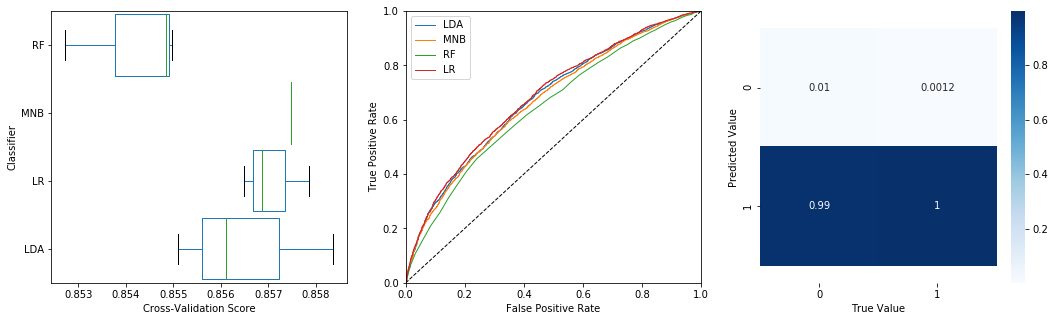

In [271]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

ax = pd.DataFrame(unbalset).boxplot(widths=(0.9,0.9,0.9,0.9), grid=False, vert=False, ax=axes[0])
ax.set_ylabel('Classifier')
ax.set_xlabel('Cross-Validation Score')

for i in range(0, len(tp_unbalset)):
    axes[1].plot(fp_unbalset[i], tp_unbalset[i], lw=1)

axes[1].plot([0, 1], [0, 1], '--k', lw=1)
axes[1].legend(models.keys())
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_xlim(0,1)
axes[1].set_ylim(0,1)

cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)

ax = sns.heatmap(cm, annot=True, cmap='Blues', ax=axes[2]);
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')
ax.axis('equal')

The cross-validation scores and ROC curves suggest the Logistic Regression is the best model, though the MNB and linear discriminant analysis models are pretty close behind. If we look at the confusion matrix, though, we see a big problem.The model can predict who are going to pay off the loan with a good accuracy of 99% but cannot predict who are going to default. The true positive rate of default (0 predicting 0) is almost 0. Since our main goal is to predict defaulter's, we have to do something about this.

The reason this is happening could be because of high imbalance in our dataset and the algorithm is putting everything into 1. We have to chose a new prediction threshold according to the sensitivity and specificity of the model. This will create some balance in predicting the binary outcome. Let's look at the plots below.

In [272]:
fp, tp, threshold = roc_curve(yte, model.predict_proba(Xte)[:,1]) #getting false and true positive from test set

Text(0,0.5,'True Positive & False Positive Rates')

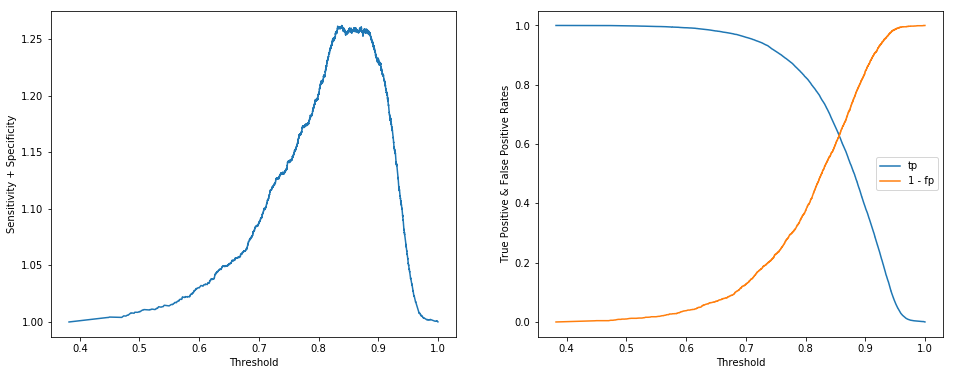

In [273]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].plot(threshold, tp + (1 - fp))
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Sensitivity + Specificity')

ax[1].plot(threshold, tp, label="tp")
ax[1].plot(threshold, 1 - fp, label="1 - fp")
ax[1].legend()
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('True Positive & False Positive Rates')

In [274]:
##finding the optimal threshold for the model 
function = tp + (1 - fp)
index = np.argmax(function)

optimal_threshold = threshold[np.argmax(function)]
print('optimal threshold:', optimal_threshold)

optimal threshold: 0.8388054199772907


The optimal threshold above is where the the two graphs meet.

Sensitivity (also called the true positive rate, the recall, or probability of detection in some fields) measures the proportion of actual positives that are correctly identified as such (e.g., the percentage of sick people who are correctly identified as having the condition).

Specificity (also called the true negative rate) measures the proportion of actual negatives that are correctly identified as such (e.g., the percentage of healthy people who are correctly identified as not having the condition)

Now using this threshold for the model:

(0.0, 2.0, 2.0, 0.0)

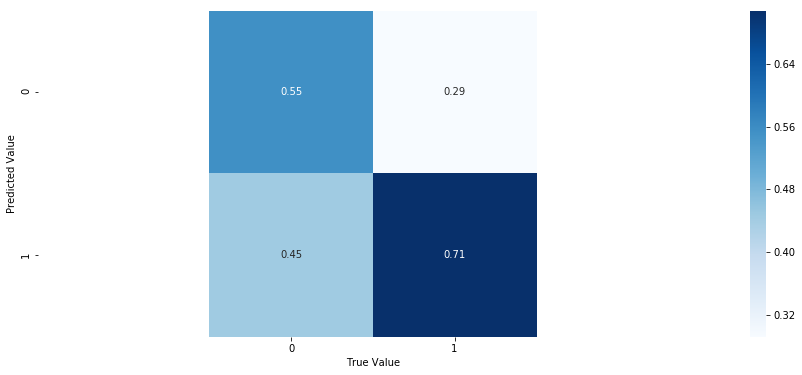

In [275]:
predict = model.predict_proba(Xte)[:,1]
predict = np.where(predict >= optimal_threshold, 1, 0)

fig, axes = plt.subplots(figsize=(15,6))

cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)

ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')
ax.axis('equal')

The optimum threshold for the classifier have increased out models prediction power of Default (0). Even now the model doesn't provide a lot of prediction power and we have to train the model again using a different algorithm with some tweaks.

### Balancing the training dataset and creating a new model
Now we will try to use a balanced dataset with equal amount of zeroes and 1's. The following part does the same.

In [276]:
y_default = traindata[traindata['loan_status'] == 0]
n_paid = traindata[traindata['loan_status'] == 1].sample(n=len(y_default), random_state=17) ##chosing equal amount of 1's

##creating a new dataframe for balanced set
data = y_default.append(n_paid) 

##creating the independent and dependent array
Xbal = data.drop('loan_status', axis=1)
ybal = data['loan_status']

In [277]:
## scaling it again
numerical = Xbal.columns[(Xbal.dtypes == 'float64') | (Xbal.dtypes == 'int64')].tolist()
Xbal[numerical] = sc.fit_transform(Xbal[numerical])

Training the model on the balanced set

In [278]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

models = {'LDA': LinearDiscriminantAnalysis(),
          'MNB': MultinomialNB(),
          'RF': RandomForestClassifier(n_estimators=100),
          'LR': LogisticRegression(C=1)}

balset = {}
for i in models.keys():
    scores = cross_val_score(models[i], Xbal - np.min(Xbal) + 1,
                                    ybal, scoring='roc_auc', cv=3)
    balset[i] = scores
    print(i, scores, np.mean(scores))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA [0.67223373 0.70324646 0.67097941] 0.6821531996429115
MNB [0.66684008 0.70087857 0.65746495] 0.6750611996055852
RF [0.65542834 0.67227339 0.64347575] 0.6570591580634693
LR [0.67401684 0.70523331 0.67161474] 0.6836216272822191


Even though we almost got the same result as before, This time we are going to select Random Forst method and will try to find the optimal number of trees using the gridsearchcv and try to make the predition based on this and lets see if there is any improvements in predicting 0's

In [279]:
model = RandomForestClassifier(n_estimators=100)
model.fit(Xbal, ybal)
predict = model.predict(Xte)

(0.0, 2.0, 2.0, 0.0)

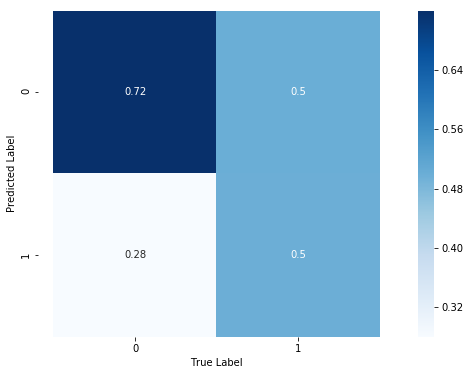

In [280]:
predict = model.predict(Xte)
fig, axes = plt.subplots(figsize=(8,6))
cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.axis('equal')

That's a significant improvement over the last model that we built using Logistic regression.

Let's find the optimum number of estimators for this model and use that for prediction. This time we are going to use 5 fold cross validation.

In [281]:
params = {'n_estimators': [50, 100, 200, 400, 600, 800]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=params,
                                   scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(Xbal, ybal)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'n_estimators': 800}
0.6134626690182245


The best model has 800 trees

In [282]:
grid_search.best_estimator_.fit(Xbal, ybal)
predict = model.predict(Xte)

(0.0, 2.0, 2.0, 0.0)

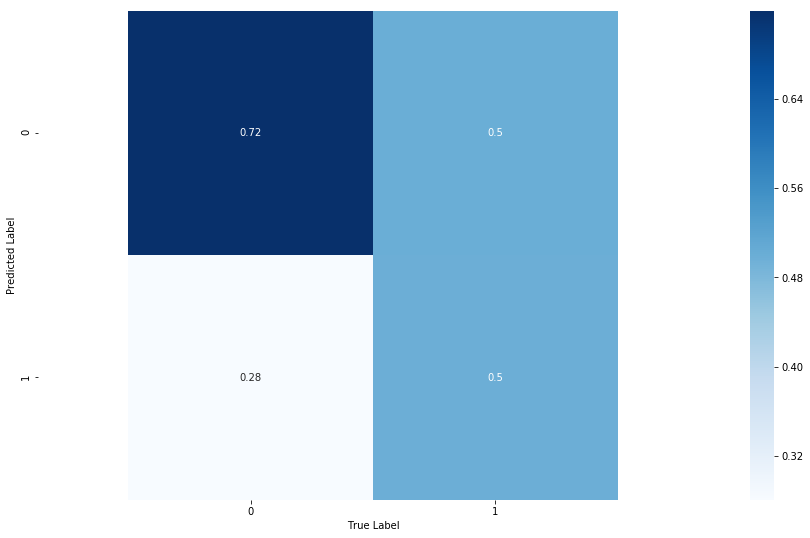

In [283]:
fig, axes = plt.subplots(figsize=(8,6))
cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.axis('equal')

Interestingly, this gives us the same output as the previous model. Even now we have a good accuracy of 72% predicting defaluter's as defaulter's.

Since random forest is based on decision trees, we can also plot the variable importance. Variable importance tells us which variable had highest importance when predicting an outcome.